<div align="center">
  <h1 style="color:darkblue"> Classificação de sentimentos nos Tweets - Parte 1🐦</h1>
</div>

Nesse notebook, vamos abordar um problema de classificação de sentimentos em tweets. O objetivo é classificar os tweets em cinco categorias: muito negativo, negativo, neutro, positivo e muito positivo. 

In [ ]:
# %%bash

# python -m spacy download en_core_web_md

## 1. Importando as bibliotecas necessárias

In [ ]:
from collections import Counter

from tqdm.auto import tqdm

import pandas as pd
import matplotlib.pyplot as plt

import spacy
import numpy as np
import itertools

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# Palavras que não são relevantes para a análise, obtidas a partir da análise de frequência
CUSTOM_STOPWORDS = {
    "covid",
    "coronavirus",
    "corona",
    "coranaviru",
    "coronacrisis",
    "coronavirusoutbreak",
    "coronaviruspandemic",
    "coronavirusupdate",
    "coronavirusupdates",
    "coronavirususa",
    "coronavirusuk",
    "coviduk",
    "covidusa",
}


nlp = spacy.load("en_core_web_md")
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS | CUSTOM_STOPWORDS

In [ ]:
df = pd.read_csv("../data/Corona_NLP_train.csv", encoding="latin1")
df = df[["OriginalTweet", "Sentiment"]]
df.sample(5)

## 2. Preprocessamento

In [ ]:
def preprocess_text(text):
    return (
        text.str.lower()
        # remove links
        .str.replace(r"https\S+|www\S+|https\S+", "", regex=True)
        # remove usernames
        .str.replace(r"\@\w+", "", regex=True)
        # remove hashtags
        .str.replace(r"\#(\w+)", "", regex=True)
        # remove non-ascii characters
        .str.normalize("NFKD")
        .str.encode("ascii", errors="ignore")
        .str.decode("utf-8")
        # manter apenas letras, espaços e apóstrofos
        .str.replace(r"[^a-z\s\']", "", regex=True)
        # remove excesso de espaços
        .str.replace(r"\s+", " ", regex=True)
        # remove espaços no começo e no fim
        .str.strip()
    )


df["CleanTweet"] = preprocess_text(df["OriginalTweet"])
df["CleanTweetNoStopwords"] = df["CleanTweet"].apply(
    lambda text: " ".join([word for word in text.split() if word not in STOPWORDS])
)
df = df.loc[df["CleanTweet"].str.split().str.len() > 2]
df = df.drop_duplicates(subset=["CleanTweet", "Sentiment"])
df.sample(5)

No notebook de exploração de dados, vimos que mais da metade do vocabulário dos tweets era composto por palavras de frequência única. Para acelerar o processamento, vamos remover essas palavras do vocabulário.

In [ ]:
words = df["CleanTweet"].str.cat(sep=" ").split()
types = Counter(words)
hapax = set([word for word, count in types.items() if count <= 1])

print(f"Total de palavras: {len(words):,}")
print(f"Tamanho do vocabulário: {len(types):,}")
print(f"Palavras únicas: {len(hapax):,}")

In [ ]:
df["CleanTweet"] = df["CleanTweet"].apply(
    lambda text: " ".join([word for word in text.split() if word not in hapax])
)
# remove tweets com menos de 3 palavras
df = df.loc[df["CleanTweet"].str.split().str.len() > 2]
df.shape

In [ ]:
docs = nlp.pipe(df["CleanTweet"])

df["Lemmatized"] = [
    " ".join([token.lemma_ for token in doc])
    for doc in tqdm(docs, total=len(df), desc="Lemmatizing")
]

docs = nlp.pipe(df["Lemmatized"])
df["LemmatizedNoStopwords"] = [
    " ".join([token.text for token in doc if token.text not in STOPWORDS])
    for doc in tqdm(docs, total=len(df), desc="Extracting stopwords")
]

## 3. Treinamento

No pré-processamento, criamos quatro colunas no dataframe de treino: 
- `CleanTweet`: tweets padronizados em minúsculas e sem caracteres especiais
- `CleanTweetNoStopwords`: tweets padronizados sem stopwords
- `Lemmatized`: tweets padronizados e lematizados
- `LemmatizedNoStopwords`: tweets padronizados, lematizados e sem stopwords

Pretendemos treinar um modelo para cada coluna a fim de comparar a performance dos modelos.

In [ ]:
df["Sentiment"] = pd.Categorical(
    df["Sentiment"],
    categories=[
        "Extremely Negative",
        "Negative",
        "Neutral",
        "Positive",
        "Extremely Positive",
    ],
    ordered=True,
)

In [ ]:
def plot_confusion_matrix(
    confusion_matrix, target_names, title="Confusion matrix", cmap=None, normalize=True
):
    if cmap is None:
        cmap = plt.get_cmap("Blues")

    plt.figure(figsize=(6, 6))
    plt.imshow(confusion_matrix, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = range(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        confusion_matrix = (
            confusion_matrix.astype("float")
            / confusion_matrix.sum(axis=1)[:, np.newaxis]
        )

    thresh = confusion_matrix.max() / 1.5 if normalize else confusion_matrix.max() / 2
    for i, j in itertools.product(
        range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])
    ):
        if normalize:
            plt.text(
                j,
                i,
                "{:0.4f}".format(confusion_matrix[i, j]),
                horizontalalignment="center",
                color="white" if confusion_matrix[i, j] > thresh else "black",
            )
        else:
            plt.text(
                j,
                i,
                "{:,}".format(confusion_matrix[i, j]),
                horizontalalignment="center",
                color="white" if confusion_matrix[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


def evaluate_model(model, vectorizer_func, X_train, y_train, cv=5):
    X_train_vectorized = vectorizer_func(X_train)

    scoring = {
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score, average="weighted"),
        "recall": make_scorer(recall_score, average="weighted"),
        "f1_score": make_scorer(f1_score, average="weighted"),
    }

    scores = cross_validate(model, X_train_vectorized, y_train, cv=cv, scoring=scoring)

    return {
        "accuracy": scores["test_accuracy"].mean(),
        "precision": scores["test_precision"].mean(),
        "recall": scores["test_recall"].mean(),
        "f1_score": scores["test_f1_score"].mean(),
    }


def evaluate_models(models, vectorizers, X_train, y_train, cv=5):
    results = []

    for model_name, model in tqdm(models.items(), desc="Models"):
        for column in X_train.columns:
            print(f"Evaluating {model_name} with {column}...")
            for vectorizer_name, vectorizer in vectorizers.items():
                result = evaluate_model(
                    model, vectorizer[column], X_train[column], y_train, cv
                )
                results.append(
                    {
                        "model": model_name,
                        "column": column,
                        "vectorizer": vectorizer_name,
                        "accuracy": result["accuracy"],
                        "precision": result["precision"],
                        "recall": result["recall"],
                        "f1_score": result["f1_score"],
                    }
                )
        print()
    return pd.DataFrame(results)

In [ ]:
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForestClassifier": RandomForestClassifier(random_state=42, n_jobs=-1),
    "LinearSVC": LinearSVC(dual="auto", random_state=42),
}
df = df.reset_index(drop=True)
X = df[["CleanTweet", "CleanTweetNoStopwords", "Lemmatized", "LemmatizedNoStopwords"]]
y = df["Sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### 3.1 Bag of Words vs TF-IDF

In [ ]:
clean_count_vectorizer = CountVectorizer()

clean_no_stopwords_count_vectorizer = CountVectorizer()

lemmatized_count_vectorizer = CountVectorizer()

lemmatized_no_stopwords_count_vectorizer = CountVectorizer()

clean_tfidf_vectorizer = TfidfVectorizer()

clean_no_stopwords_tfidf_vectorizer = TfidfVectorizer()

lemmatized_tfidf_vectorizer = TfidfVectorizer()

lemmatized_no_stopwords_tfidf_vectorizer = TfidfVectorizer()

vectorizers = {
    "CountVectorizer": {
        "CleanTweet": clean_count_vectorizer.fit(X_train["CleanTweet"]),
        "CleanTweetNoStopwords": clean_no_stopwords_count_vectorizer.fit(
            X_train["CleanTweetNoStopwords"]
        ),
        "Lemmatized": lemmatized_count_vectorizer.fit(X_train["Lemmatized"]),
        "LemmatizedNoStopwords": lemmatized_no_stopwords_count_vectorizer.fit(
            X_train["LemmatizedNoStopwords"]
        ),
    },
    "TfidfVectorizer": {
        "CleanTweet": clean_tfidf_vectorizer.fit(X_train["CleanTweet"]),
        "CleanTweetNoStopwords": clean_no_stopwords_tfidf_vectorizer.fit(
            X_train["CleanTweetNoStopwords"]
        ),
        "Lemmatized": lemmatized_tfidf_vectorizer.fit(X_train["Lemmatized"]),
        "LemmatizedNoStopwords": lemmatized_no_stopwords_tfidf_vectorizer.fit(
            X_train["LemmatizedNoStopwords"]
        ),
    },
}

In [ ]:
vectorizers_func = {
    "CountVectorizer": {
        "CleanTweet": clean_count_vectorizer.transform,
        "CleanTweetNoStopwords": clean_no_stopwords_count_vectorizer.transform,
        "Lemmatized": lemmatized_count_vectorizer.transform,
        "LemmatizedNoStopwords": lemmatized_no_stopwords_count_vectorizer.transform,
    },
    "TfidfVectorizer": {
        "CleanTweet": clean_tfidf_vectorizer.transform,
        "CleanTweetNoStopwords": clean_no_stopwords_tfidf_vectorizer.transform,
        "Lemmatized": lemmatized_tfidf_vectorizer.transform,
        "LemmatizedNoStopwords": lemmatized_no_stopwords_tfidf_vectorizer.transform,
    },
}

results = evaluate_models(models, vectorizers_func, X_train, y_train)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, column in enumerate(X_train.columns):
    ax = axes[i]
    data = results.loc[results["column"] == column]
    data = data.pivot(index="model", columns="vectorizer", values="f1_score")
    data.plot(kind="bar", ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(column)
    ax.set_ylim(0, 1)
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=8,
        )

# main title
plt.suptitle("F1 Score", fontsize=16)

plt.tight_layout()
plt.show()

Após comparar a performance dos modelos, vimos que a regressão logística com Bag of Words teve o melhor desempenho médio na validação cruzada. As colunas `CleanTweet` e `Lemmatized` tiveram os melhores resultados. No entanto, a diferença entre os resultados foi muito pequena. Vamos agora comparar usando embeddings de palavras e sequências de palavras.

Melhor Regressão Logística na coluna `Leammatized`:
- Bag of Words (BoW) F1-score: 0.62
- TF-IDF F1-score: 0.57

### 3.2 Word Embeddings

In [ ]:
clean_tweets_vec = np.array(
    [
        doc.vector
        for doc in tqdm(
            nlp.pipe(df["CleanTweet"]), total=len(df), desc="Vectorizing tweets"
        )
    ]
)

clean_no_stopwords_vec = np.array(
    [
        doc.vector
        for doc in tqdm(
            nlp.pipe(df["CleanTweetNoStopwords"]),
            total=len(df),
            desc="Vectorizing tweets",
        )
    ]
)

lemmatized_vec = np.array(
    [
        doc.vector
        for doc in tqdm(
            nlp.pipe(df["Lemmatized"]), total=len(df), desc="Vectorizing tweets"
        )
    ]
)

lemmatized_no_stopwords_vec = np.array(
    [
        doc.vector
        for doc in tqdm(
            nlp.pipe(df["LemmatizedNoStopwords"]),
            total=len(df),
            desc="Vectorizing tweets",
        )
    ]
)

Para avaliação dos *embeddings* removemos os modelos `MultinomialNB`, pois ele não aceita valores negativos e o `LogisticRegression` pois não estava convergindo.

In [ ]:
del models["MultinomialNB"]  # não aceita valores negativos
del models["LogisticRegression"]  # não está convergindo

In [ ]:
results3 = evaluate_models(
    models,
    {
        "Doc2Vec": {
            "CleanTweet": lambda x: clean_tweets_vec[x.index],
            "CleanTweetNoStopwords": lambda x: clean_no_stopwords_vec[x.index],
            "Lemmatized": lambda x: lemmatized_vec[x.index],
            "LemmatizedNoStopwords": lambda x: lemmatized_no_stopwords_vec[x.index],
        }
    },
    X_train,
    y_train,
)

In [ ]:
results3

Na abordagem de *embeddings* de palavras, o modelo com melhor f1_score médio foi o `LinearSVC` com a coluna `CleanTweetNoStopwords` que foi de 0.48. Valores muito próximos entre as colunas.

### 3.2 Sentences Embeddings

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

In [ ]:
clean_embeddings = model.encode(df["CleanTweet"].tolist(), show_progress_bar=True)
clean_no_stops = model.encode(
    df["CleanTweetNoStopwords"].tolist(), show_progress_bar=True
)
lemmatized_embeddings = model.encode(df["Lemmatized"].tolist(), show_progress_bar=True)
lemmatized_no_stops = model.encode(
    df["LemmatizedNoStopwords"].tolist(), show_progress_bar=True
)

In [ ]:
results4 = evaluate_models(
    models,
    {
        "SentenceTransformer": {
            "CleanTweet": lambda x: clean_embeddings[x.index],
            "CleanTweetNoStopwords": lambda x: clean_no_stops[x.index],
            "Lemmatized": lambda x: lemmatized_embeddings[x.index],
            "LemmatizedNoStopwords": lambda x: lemmatized_no_stops[x.index],
        }
    },
    X_train,
    y_train,
)

In [ ]:
results4

Na abordagem usando Sentence Transformer, a diferença entre os modelos foi muito pequena. O modelo com melhor f1_score médio foi o `LinearSVC` com a coluna `CleanTweetNoStopwords` que foi de 0.49.

## 4. Conclusão 

O modelo com melhor F1-score médio foi a Regressão Logística com Bag of Words na coluna `Lemmatized` com 0.62.

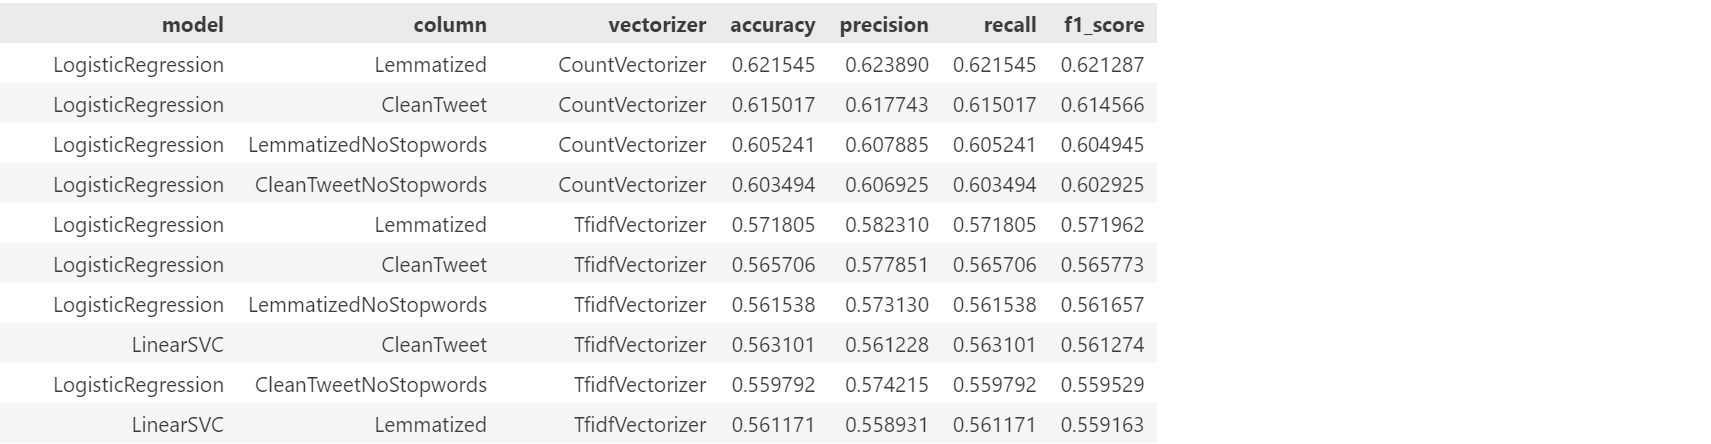

In [ ]:
results = pd.concat([results, results3, results4])
results = results.sort_values("f1_score", ascending=False)
results